# Bayesian Neural Networks
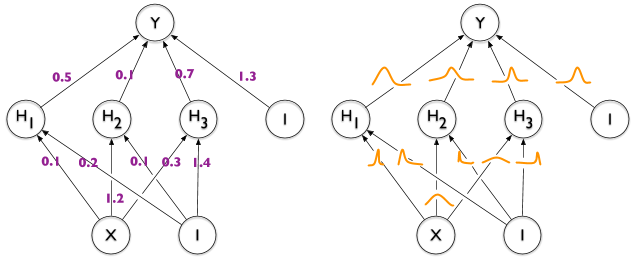

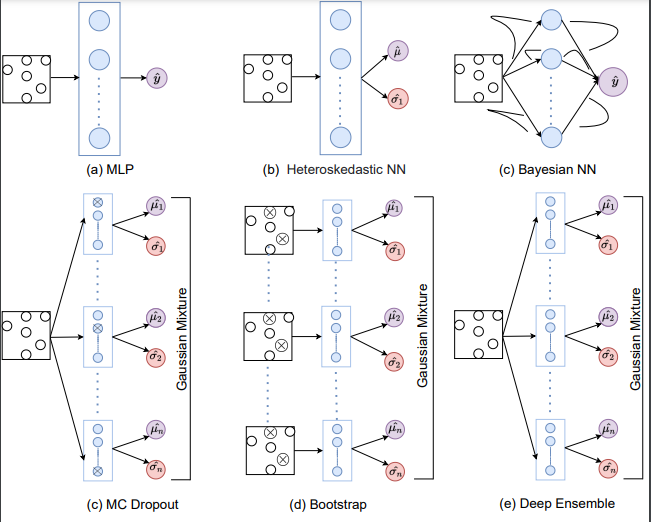

<!-- ### Non-bayesian or bayesian approximation (for today) tbh :) -->
### What all we shall cover today ? 
1. Basic MLP Forward pass & Backward pass
2. Heteroskedastic MLP
3. Mixture of Gaussians
4. Three non-bayesian ways of including uncertainty -> bayesian approximations :<br>
    a) Deep Ensemble <br>
    b) MC Dropout <br>
    c) Bootstrap <br>

### Forward Pass


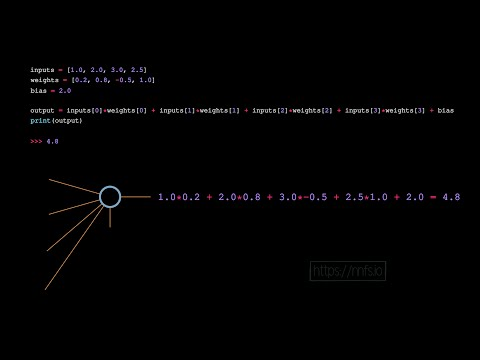

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('MBIJc6XtLjg', width=1200, height=600)

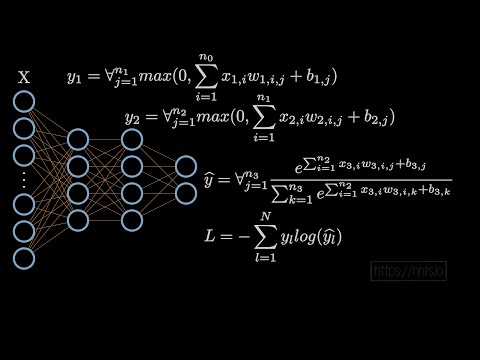

In [2]:
YouTubeVideo('xtzVuln1PV8', width=1200, height=600)

### Backward Pass

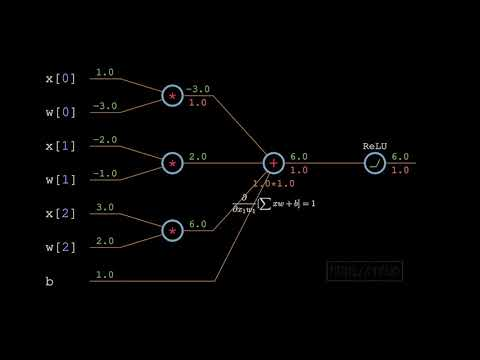

In [3]:
YouTubeVideo('_9qHQA30hys', width=1200, height=600)


$$
\begin{array}{l|l}
Forward & Backward \\ 
\hline
J=y^* \log y+\left(1-y^*\right) \log (1-y) & \frac{d J}{d y}=\frac{y^*}{y}+\frac{\left(1-y^*\right)}{y-1} \\
\hline
\end{array}
$$



$$
\begin{array}{l|l}
Forward & Backward \\ \hline
J=y^* \log y+\left(1-y^*\right) \log (1-y) & \frac{d J}{d y}=\frac{y^*}{y}+\frac{\left(1-y^*\right)}{y-1} \\
\hline y=\frac{1}{1+\exp (-a)} & \frac{d J}{d a}=\frac{d J}{d y} \frac{d y}{d a}, \frac{d y}{d a}=\frac{\exp (-a)}{(\exp (-a)+1)^2} \\
\hline
a=\sum_{j=0}^D \theta_j x_j & \frac{d J}{d \theta_j}=\frac{d J}{d a} \frac{d a}{d \theta_j}, \frac{d a}{d \theta_j}=x_j \\
&\frac{d J}{d x_j}=\frac{d J}{d a} \frac{d a}{d x_j}, \frac{d a}{d x_j}=\theta_j
\end{array}
$$


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [5]:
def target_toy(key, x):
    epsilons = jax.random.normal(key, shape=(1,)) * 2

    return 10 * x * x +  x * epsilons*3


def data_set(n_points=100):
    key, subkey = jax.random.split(jax.random.PRNGKey(4))
    x = jnp.linspace(-3, 3, n_points).reshape(-1, 1)
    x_test_1 = jnp.linspace(-4, -3, n_points).reshape(-1, 1)
    x_test_2 = jnp.linspace(3, 4, n_points).reshape(-1, 1)
    target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)
    keys = jax.random.split(subkey, x.shape[0])
    y = target_vmap(keys, x)
    y_test_1 = target_vmap(keys, x_test_1)
    y_test_2 = target_vmap(keys, x_test_2)
    x_test = jnp.concatenate([x_test_1, x_test_2], axis=0)
    y_test = jnp.concatenate([y_test_1, y_test_2], axis=0)
    return x, y, x_test, y_test

In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import jax.numpy as jnp
import seaborn as sns
import jax
import jax
from flax import linen as nn 
import matplotlib.pyplot as plt

%matplotlib inline
x, y, x_ood, y_ood = data_set()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

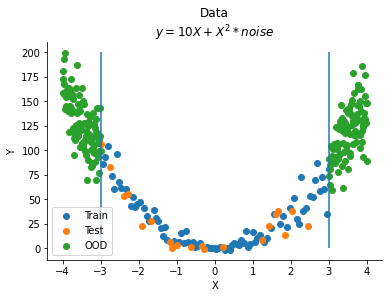

In [7]:
plt.scatter(x_train, y_train,label='Train')
plt.scatter(x_test, y_test,label='Test')
plt.scatter(x_ood, y_ood,label='OOD')

plt.vlines(x=3,ymin=0,ymax=200)
plt.vlines(x=-3,ymin=0,ymax=200)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Data\n$y=10X+X^2*noise$')
sns.despine()

In [8]:

from flax import linen as nn
class MLP(nn.Module):
    features: list
    activations: list
    dropout_rate: list

    @nn.compact
    def __call__(self, X, deterministic):
        if len(self.activations) != len(self.features) - 1:
            raise Exception(
                f"Length of activations should be equal to {len(self.features) - 1}"
            )

        if len(self.dropout_rate) != len(self.features) - 1:
            raise Exception(
                f"Length of dropout_rate should be equal to {len(self.features) - 1}"
            )

        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, name=f"{i}_Dense")(X)
            if i != len(self.features) - 1:
                X = self.activations[i](X)
                X = nn.Dropout(
                    rate=self.dropout_rate[i],
                    deterministic=deterministic,
                    name=f"{i}_Dropout_{self.dropout_rate[i]}",
                )(X)
        return X

    def loss_fn(self, params, X, y, deterministic=False, rng=jax.random.PRNGKey(0)):
        y_pred = self.apply(
            params, X, deterministic=deterministic, rngs={"dropout": rng}
        )
        loss = jnp.mean((y - y_pred) ** 2)
        return loss

In [9]:
import jax
import jax.numpy as jnp
import optax
from functools import partial


def fit(
    model,
    params,
    X,
    y,
    deterministic,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    rng=jax.random.PRNGKey(0),
):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_fn = partial(model.loss_fn, deterministic=deterministic)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    losses = []
    total_epochs = (len(X) // batch_size) * epochs

    carry = {}
    carry["params"] = params
    carry["state"] = opt_state

    @jax.jit
    def one_epoch(carry, rng):
        params = carry["params"]
        opt_state = carry["state"]
        idx = jax.random.choice(
            rng, jnp.arange(len(X)), shape=(batch_size,), replace=False
        )
        loss_val, grads = loss_grad_fn(params, X[idx], y[idx], rng=rng)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        carry["params"] = params
        carry["state"] = opt_state

        return carry, loss_val

    carry, losses = jax.lax.scan(one_epoch, carry, jax.random.split(rng, total_epochs))
    return carry["params"], losses

In [10]:
mlp = MLP([64,32, 1], [nn.relu] * 2, [0] * 2)
mlp_params = mlp.init(jax.random.PRNGKey(0), x_train, True)
mlp_params, mlp_loss = fit(
    mlp, mlp_params, x_train, y_train, True, learning_rate=0.001, epochs=1000
)

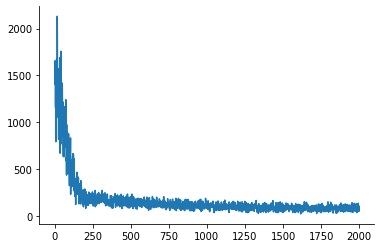

In [11]:
plt.plot(mlp_loss)
sns.despine()

In [12]:
mlp_loss[-1]

DeviceArray(52.254814, dtype=float32)

In [13]:
def plot_prediction_reg(
    X_train,
    Y_train,
    x_test,
    y_test,
    X_linspace,
    predict_mean,
    predict_sigma,
    title,
    y_min=None,
    y_max=None,
    marker_size=None,
    ax=None,

):

    if ax == None:
        fig, ax = plt.subplots(1)
    ax.plot(X_linspace, predict_mean, color="red")
    for i_std in range(1, 4):
        ax.fill_between(
            X_linspace.reshape((-1,)),
            jnp.array((predict_mean - i_std * predict_sigma)),
            jnp.array((predict_mean + i_std * predict_sigma)),
            color="lightsalmon",
            alpha=3/ (4 * i_std),
            label=f"$\mu\pm{i_std}\sigma$",
        )

    ax.scatter(x_test, y_test, color="blue", alpha=0.5,s=marker_size,label='Test')
    ax.scatter(X_train, Y_train, color="black", alpha=0.5,s=marker_size,label='Train')
    ax.vlines(min(X_train),y_min,y_max,  colors="black",
        linestyles="--",)
    ax.vlines(max(X_train),y_min,y_max,  colors="black",
        linestyles="--",)
    ax.set_ylim([y_min,y_max])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
#     ax.xlim([min(x_test), max(x_test)])
    ax.set_title(title)
    sns.despine()
    return ax

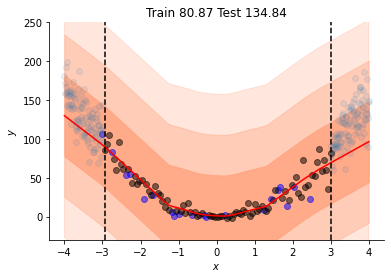

In [14]:
x_vis = jnp.linspace(-4,4,100).reshape(-1,1)
mlp_mean = mlp.apply(mlp_params, x_vis, True)
mlp_mean_test = mlp.apply(mlp_params, x_test, True)
mlp_mean_train = mlp.apply(mlp_params, x_train, True)
mlp_train_loss = mlp.loss_fn(mlp_params, x_train,y_train, True, jax.random.PRNGKey(0))
mlp_test_loss =  mlp.loss_fn(mlp_params, x_test, y_test, True, jax.random.PRNGKey(0))
ax = plot_prediction_reg(
    x_train,
    y_train,
    x_test,
    y_test,
    x_vis,
    mlp_mean.reshape(-1),
    mlp_loss[-1],
    f"Train {mlp_train_loss:.2f} Test {mlp_test_loss:.2f}",y_min=-30,y_max=250
)
ax.scatter(x_ood,y_ood,alpha=0.1)

### Ideally we want =>
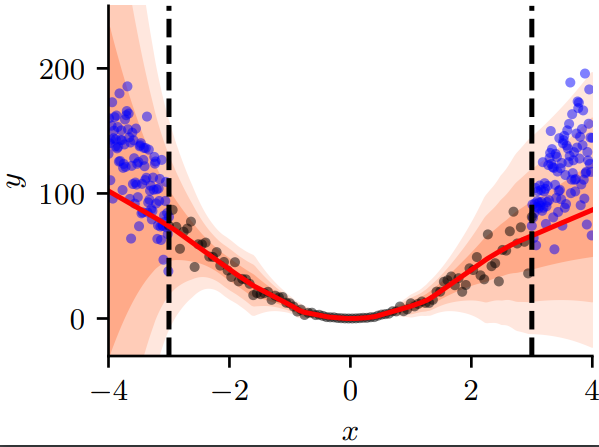

### Heteroskedastic NN
#### Assumption 
We assume normal distribution as a standard convention, but we can have variety of distributions here !
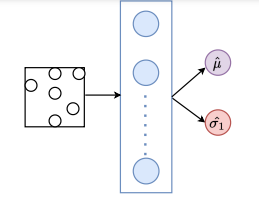

#### What is the mistake in this pseudo code ?
class gmlp(nn.Module):<br>
    features: list
    activations: list

    @nn.compact
    def __call__(self, X, deterministic):
        for i, feature in enumerate(self.features):
            X = nn.Dense(
                feature)(X)
            X = self.activations[i](X)
        X = nn.Dense(2, name=f"Gaussian")(X)
        mean = X[:, 0]
        sigma = X[:, 1]


X = nn.Dense(2, name=f"Gaussian")(X) <br>
mean = X[:, 0] <br>
sigma = nn.softplus(X[:, 1]) $$ Softplus => log(1 + e^X) $$<br>



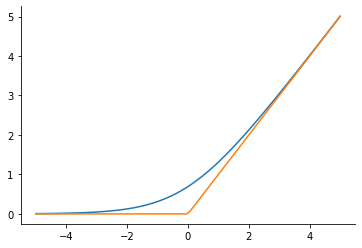

In [15]:
x = jnp.linspace(-5,5,100)
y = nn.softplus(x)
y1 = nn.relu(x)
plt.plot(x,y)
plt.plot(x,y1)
sns.despine()

#### What will be loss function for heteroskedastic regression ?

$$
loss=\dfrac{\sum_{i=1}^{N}\left(-\frac{1}{2} \log \sigma^{2}-\frac{1}{2 \sigma^{2}}\left(y_{i}- \hat{y}_i\right)^{2}\right)}{N}
$$

In [16]:
from flax import linen as nn
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
class gmlp(nn.Module):
    features: list
    activations: list
    dropout_rate: list

    @nn.compact
    def __call__(self, X, deterministic):
        for i, feature in enumerate(self.features):
            X = nn.Dense(
                feature,
                kernel_init=jax.nn.initializers.glorot_normal())(X)
            X = self.activations[i](X)
            X = nn.Dropout(rate=self.dropout_rate[i],
                deterministic=deterministic,
                name=f"{i}_Dropout_{self.dropout_rate[i]}",)(X)
        X = nn.Dense(2, name=f"Gaussian")(X)
        mean = X[:, 0]
        sigma = nn.softplus(X[:, 1])
        return mean, sigma

    def loss_fn(self, params, X, y, deterministic=False, rng=jax.random.PRNGKey(0)):
        mean, sigma = self.apply(
            params, X, deterministic=deterministic, rngs={"dropout": rng}
        )

        def loss(mean, sigma, y):
            d = dist.Normal(loc=mean, scale=sigma)
            return -d.log_prob(y)

        return jnp.mean(jax.vmap(loss, in_axes=(0, 0, 0))(mean, sigma, y))

In [33]:
gmlp_model = gmlp(features=[64, 32], activations=[nn.relu] * 2, dropout_rate=[0.0] * 2)

In [18]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(100), x_train, True)
gmlp_params, loss = fit(
    gmlp_model,
    gmlp_params,
    x_train,
    y_train,
    deterministic=True,
    learning_rate=0.001,
    epochs=2500,
)

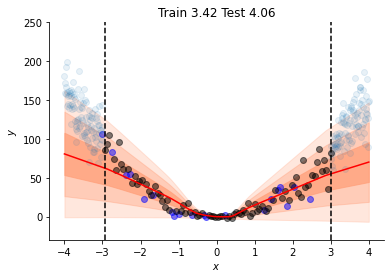

In [19]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_vis, True)
gmlp_mean_test, gmlp_sigma_test = gmlp_model.apply(gmlp_params, x_test, True)
gmlp_mean_train, gmlp_sigma_train = gmlp_model.apply(gmlp_params, x_train, True)
gmlp_train_loss = gmlp_model.loss_fn(gmlp_params, x_train,y_train, True, jax.random.PRNGKey(0))
gmlp_test_loss =  gmlp_model.loss_fn(gmlp_params, x_test, y_test, True, jax.random.PRNGKey(0))
ax = plot_prediction_reg(
    x_train,
    y_train,
    x_test,
    y_test,
    x_vis,
    gmlp_mean,
    gmlp_sigma,
    f"Train {gmlp_train_loss:.2f} Test {gmlp_test_loss:.2f}",y_min=-30,y_max=250
)
ax.scatter(x_ood,y_ood,alpha=0.1)

## Mixture of Gaussians

$$
\mathcal{N}\left(\boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)=\sum_{i=1}^N p_i \mathcal{N}\left(\boldsymbol{x} \mid \boldsymbol{\mu}_i, \boldsymbol{\Sigma}_i\right)
$$


In [20]:
def style_plot(ax, grid=True):
    if grid:
        ax.grid(grid, color='w')
        ax.set_axisbelow(True)
    ax.set_facecolor("#F0EDF0")
    
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('w')
    ax.spines['bottom'].set_color('w')

In [21]:
from ipywidgets import interact
from scipy.stats import norm
@interact(pi=(0.0,1.0))
def generate_random(pi=0.5):
    fig, ax = plt.subplots(frameon=False, linewidth=3)
    ax.set_position([0, 0, 1, 1])
    ax.set_ylim(-0.03, 1.2)
    ax.set_xlim(-3, 4)
    x = jnp.linspace(-3, 4, 100)
    pdf1 = norm.pdf(x, -1, 1)
    pdf2 = norm.pdf(x, 2, 0.5)
    style_plot(ax)
    line, = ax.plot(x, pi * pdf2 + (1-pi) * pdf1, "#00848C")
    ax.plot(x, pdf1, '#48CFAF')
    ax.plot(x, pdf2, '#48CFAF')


interactive(children=(FloatSlider(value=0.5, description='pi', max=1.0), Output()), _dom_classes=('widget-inte…

$$
\mu_{ensemble}=\frac{\sum_{i=1}^N p_i \mu_i}{N}
$$

But what will be sigma ?


$$
\sigma^2_{ensemble}=\frac{\sum_i p_i \sigma_i^2+\sum_i p_i\left(\mu_i^{(1)}\right)^2}{N}-\left(\sum_i p_i \mu_i^{(1)}\right)^2
$$
If we assume individual weight of distributions in mixture equal, then
$$
\sigma^2_{ensemble} = {\frac{\sum_{i=1}^{N}(\sigma_i^2+\mu_i^2)}{N}-\mu_\textrm{ensemble}^2}
$$

$$
\mu_{ensemble}=\frac{\sum_{i=1}^N p_i \mu_i}{N}
$$
$$
\sigma^2_{ensemble} = {\frac{\sum_{i=1}^{N}(\sigma_i^2+\mu_i^2)}{N}-\mu_\textrm{ensemble}^2}
$$

In [22]:
def gmm_mean_var(means_stack, sigmas_stack):
    means = jnp.stack(means_stack)
    final_mean = means.mean(axis=0)
    sigmas = jnp.stack(sigmas_stack)
    final_sigma = (sigmas + means ** 2).mean(axis=0) - final_mean ** 2)
    return final_mean, final_sigma

the variance of the mixture is the mixture of the variances plus a non-negative term accounting for the (weighted) dispersion of the means.

## 3 Ways of bayesian approimation 
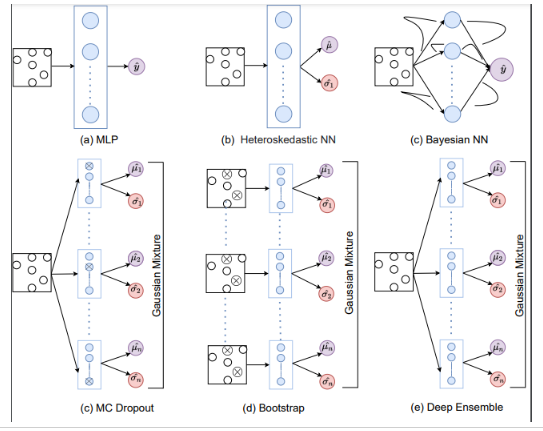

## MC Dropout
At the time of prediction, it randomly drops out nodes from the network. The probability of a node being dropped (or retained) is given as per the Bernoulli distribution



In [23]:
n_stacks = 10
fn = lambda x, i : gmlp_model.apply(gmlp_params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

In [24]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_vis, jnp.arange(n_stacks))
mc_mean,mc_sigma =  gmm_mean_var(y_stacks[0],y_stacks[1])


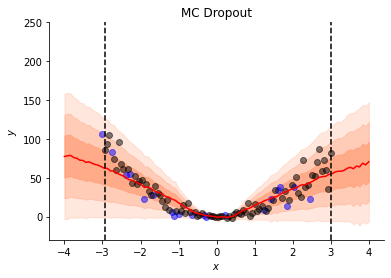

In [25]:
mc_mean, mc_sigma = mc_mean.reshape(-1), mc_sigma.reshape(-1)
plot_prediction_reg(
    x_train,
    y_train,
    x_test,
    y_test,
    x_vis,
    mc_mean,
    mc_sigma,
title='MC Dropout',
    y_min=-30,y_max=250
)
sns.despine()

## Bootstrap
Bootstrap aggregating is a technique used to reduce the variance
of a machine learning model. It works by training multiple
models on different subsets of the data and then
averaging the predictions of all the models. 

In [26]:
def predict(x, param, model):
    yhat,sigma= model.apply(param,x,True)
    return yhat,sigma

In [27]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, learning_rate=0.003, epochs=2000)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=gmlp_model)
bs_params_list, bs_losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [28]:
test_ = jax.tree_util.Partial(predict, model=gmlp_model)
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_vis, bs_params_list)
bs_mean,bs_sigma=gmm_mean_var(y_stacks[0],y_stacks[1])

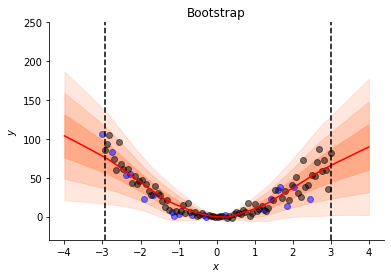

In [29]:
bs_mean, bs_sigma = bs_mean.reshape(-1), bs_sigma.reshape(-1)
plot_prediction_reg(
    x_train,
    y_train,
    x_test,
    y_test,
    x_vis,
    bs_mean,
    bs_sigma,
title='Bootstrap',
    y_min=-30,y_max=250
)
sns.despine()

## Deep Ensemble
The models can be of different types (e.g., different neural network architectures), or they can be different instances
of the same type of model (e.g., different random initialisations of the same architecture)


In [30]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=32, 
                       learning_rate=0.001,epochs=2500,)
    return param, losses

In [31]:

de_train = jax.tree_util.Partial(de_train, model=gmlp_model)
de_params_list, de_losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_vis, de_params_list)
de_mean,de_sigma=gmm_mean_var(y_stacks[0],y_stacks[1])

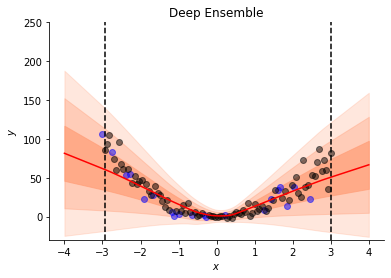

In [32]:
de_mean, de_sigma = de_mean.reshape(-1), de_sigma.reshape(-1)
plot_prediction_reg(
    x_train,
    y_train,
    x_test,
    y_test,
    x_vis,
    de_mean,
    de_sigma,
title='Deep Ensemble',
    y_min=-30,y_max=250
)
sns.despine()

## Comparison 

 Training Time : DE > Bootstrap >> MC Dropout <br>
Testing Time : DE = Bootstrap = MC Dropout 